In [1]:
%matplotlib inline
from pylab import *
import xarray as xr
from xgcm import Grid
import seawater as sw
import gsw
import scipy.signal as sig
from xhistogram.xarray import histogram
import glob
# from dask.distributed import Client,progress
# from dask_gateway import Gateway

In [2]:
basedir='/vortexfs1/home/ilebras/'
datadir=basedir+'data/'
figdir=basedir+'figures/NASA_AMOC/August2022_bathy/'

In [3]:
start_date='2004-5-1'
end_date='2019-4-1'

### Load ERA5

In [4]:
era5=xr.open_dataset(datadir+'WindStress/ERA5/ERA5_monthlywindstress_NA_2001_2020_downloaded210414.nc')

### Calculate wind stress from wind speed for CCMP

load ccmp from subsampled netcdf

In [5]:
ccmp=xr.open_dataset(datadir+'WindStress/CCMP/ccmp_1987to2019_monthly.nc').sel(time=slice(start_date,end_date))


calculate drag coefficient as per McCarthy et al. 2015, who references Smith 1980

In [6]:
ccmp['cd_u']=(0.61+0.063*ccmp.wspd)*1e-3
ccmp['cd_u']=ccmp['cd_u'].where(ccmp.wspd<7.5,1e-3)

In [7]:
ccmp['cd_v']=(0.61+0.063*ccmp.wspd)*1e-3
ccmp['cd_v']=ccmp['cd_v'].where(ccmp.wspd<7.5,1e-3)

In [8]:
rho_air=1.25 #from Wikipedia page, estimated density at 10C

In [9]:
ccmp['taux']=rho_air*ccmp.cd_u*ccmp.uwnd*ccmp.wspd
ccmp['tauy']=rho_air*ccmp.cd_v*ccmp.vwnd*ccmp.wspd

In [10]:
ccmp['longitude']=ccmp.longitude-360

In [11]:
ccmp=ccmp.rename({'time':'date'})

### Load NCEP

In [12]:
ncep=xr.open_mfdataset(datadir+'WindStress/NCEP/*.nc').rename({'initial_time0_hours':'time','g4_lat_1':'lat','g4_lon_2':'lon'})

In [13]:
ncep.lon

<xarray.DataArray 'lon' (lon: 64)>
array([260.625, 262.5  , 264.375, 266.25 , 268.125, 270.   , 271.875, 273.75 ,
       275.625, 277.5  , 279.375, 281.25 , 283.125, 285.   , 286.875, 288.75 ,
       290.625, 292.5  , 294.375, 296.25 , 298.125, 300.   , 301.875, 303.75 ,
       305.625, 307.5  , 309.375, 311.25 , 313.125, 315.   , 316.875, 318.75 ,
       320.625, 322.5  , 324.375, 326.25 , 328.125, 330.   , 331.875, 333.75 ,
       335.625, 337.5  , 339.375, 341.25 , 343.125, 345.   , 346.875, 348.75 ,
       350.625, 352.5  , 354.375, 356.25 , 358.125,   0.   ,   1.875,   3.75 ,
         5.625,   7.5  ,   9.375,  11.25 ,  13.125,  15.   ,  16.875,  18.75 ],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 260.6 262.5 264.4 266.2 ... 13.12 15.0 16.88 18.75
Attributes:
    La1:        88.542
    Lo1:        0.0
    La2:        -88.542
    Lo2:        358.125
    Di:         1.875
    N:          47.0
    units:      degrees_east
    GridType:   Gaussian Latitude/Longitude Grid
    long_name:  longitude

In [14]:
ncep.lat

<xarray.DataArray 'lat' (lat: 26)>
array([48.57052 , 46.665817, 44.76111 , 42.8564  , 40.951687, 39.04697 ,
       37.14225 , 35.23753 , 33.332806, 31.428082, 29.523355, 27.618628,
       25.7139  , 23.80917 , 21.90444 , 19.999708, 18.094976, 16.190243,
       14.28551 , 12.380776, 10.476042,  8.571308,  6.666573,  4.761838,
        2.857103,  0.952368], dtype=float32)
Coordinates:
  * lat      (lat) float32 48.57 46.67 44.76 42.86 ... 6.667 4.762 2.857 0.9524
Attributes:
    La1:        88.542
    Lo1:        0.0
    La2:        -88.542
    Lo2:        358.125
    Di:         1.875
    N:          47.0
    units:      degrees_north
    GridType:   Gaussian Latitude/Longitude Grid
    long_name:  latitude

In [15]:
ncep=ncep.sortby('lat')

In [16]:
ncep['lon']=hstack((ncep.lon.where(ncep.lon>180,drop=True)-360,ncep.lon.where(ncep.lon<=180,drop=True)))

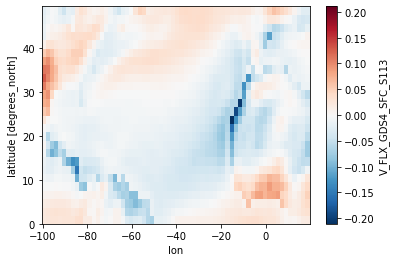

In [17]:
(-ncep.V_FLX_GDS4_SFC_S113.mean(dim='time')).plot()

(0.0, 50.0)

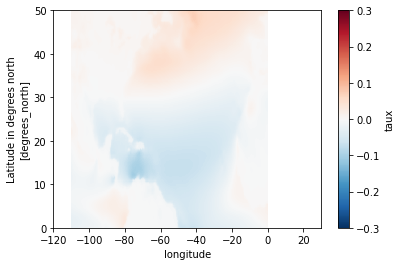

In [18]:
ccmp.taux.mean(dim='date').plot(vmin=-0.3,vmax=0.3,cmap=cm.RdBu_r)
xlim(-120,30)
ylim(0,50)

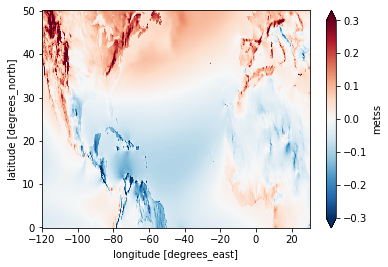

In [19]:
era5.metss.mean(dim='time').plot(vmin=-0.3,vmax=0.3,cmap=cm.RdBu_r)

## Calculate Ekman

In [20]:
theta=pi*60/180
latsel=35
rho0=1030

In [21]:
datadir

'/vortexfs1/home/ilebras/data/'

In [22]:
pos1=xr.open_dataset(datadir+'NASA_AMOC/Section35N_Step1_noLW.nc')
pos2=xr.open_dataset(datadir+'NASA_AMOC/Section35N_Step1_noLW_extension.nc')
pos=xr.concat([pos1,pos2],dim='date')
pos['theta']=(['dist'],theta*ones(len(pos.dist)))
pos['theta']=pos['theta'].where(pos.lat>latsel,0)

In [23]:
pos

<xarray.Dataset>
Dimensions:    (date: 212, depth: 201, dist: 280)
Coordinates:
    lat        (dist) float64 40.27 40.13 39.99 39.85 ... 35.0 35.0 35.0 35.0
    time       (date) float64 2.004e+03 2.004e+03 ... 2.022e+03 2.022e+03
  * date       (date) datetime64[ns] 2004-05-16T23:15:00 ... 2021-12-17T01:06...
  * depth      (depth) float32 0.0 10.0 20.0 30.0 ... 1.98e+03 1.99e+03 2e+03
    loni       (dist) float64 -70.2 -70.1 -70.0 -69.9 ... -6.625 -6.375 -6.125
  * dist       (dist) float64 0.0 17.73 35.46 ... 6.118e+03 6.141e+03 6.164e+03
Data variables:
    vg         (depth, dist, date) float64 -0.04856 -0.04699 ... nan nan
    sigma2_i   (depth, dist, date) float64 34.3 33.69 32.86 32.5 ... nan nan nan
    bathy_i    (date, dist) float64 -91.77 -164.9 -260.2 ... -306.3 -66.07 28.02
    rho_i      (depth, dist, date) float64 2.026e+03 2.025e+03 ... nan nan
    depthdiff  (date, depth) float64 5.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
    distdiff   (date, dist) float64 1.773e+04 1.773e+04 ... 2.277e+04 2.277e+04
    trans      (depth, dist, date) float64 -0.004304 -0.004165 ... nan nan
    theta      (dist) float64 1.047 1.047 1.047 1.047 1.047 ... 0.0 0.0 0.0 0.0

## ERA 5

In [24]:
era5=era5.rename({'longitude':'loni','latitude':'lat'})
era5_track=era5.interp(loni=pos.loni,lat=pos.lat)
era5_track['tau_along']=-era5_track['metss']*cos(pos.theta)+era5_track['mntss']*sin(pos.theta)
era5['Ekman']=(era5_track['tau_along']/sw.f(era5_track.lat)/rho0*pos.distdiff/1e6).sum(dim='dist')

## NCEP

In [25]:
ncep=ncep.rename({'lon':'loni'})
ncep_track=ncep.interp(loni=pos.loni,lat=pos.lat)
ncep_track['tau_along']=ncep_track['U_FLX_GDS4_SFC_S113']*cos(pos.theta)-ncep_track['V_FLX_GDS4_SFC_S113']*sin(pos.theta)
ncep['Ekman']=(ncep_track['tau_along']/sw.f(era5_track.lat)/rho0*pos.distdiff/1e6).sum(dim='dist')

## CCMP

In [71]:
# ccmp=ccmp.rename({'longitude':'loni','latitude':'lat'})
ccmp_track=ccmp.interp(loni=pos.loni,lat=pos.lat)
ccmp_track['tau_along']=-ccmp_track['taux']*cos(pos.theta)+ccmp_track['tauy']*sin(pos.theta)
ccmp['Ekman_wdist']=(ccmp_track['tau_along']/sw.f(pos.lat)/rho0*pos.distdiff.interp(date=ccmp.date)/1e6)
ccmp['Ekman']=ccmp.Ekman_wdist.sum(dim='dist')

In [73]:
Ekman=xr.Dataset(coords={'date':pos.date})

In [74]:
Ekman['CCMP']=('date',ccmp.Ekman.interp(date=pos.date))
Ekman['NCEP']=('date',ncep.Ekman.interp(time=pos.date))
Ekman['ERA5']=('date',era5.Ekman.interp(time=pos.date))

In [75]:
ccmp.Ekman

<xarray.DataArray 'Ekman' (date: 179)>
array([ 0.00000000e+00, -1.47184068e+00,  2.83605856e-01, -8.75478652e-04,
        6.27716455e-01, -1.09865141e+00,  6.56227715e-01,  8.92898302e-01,
       -6.82525928e-01, -1.25502565e-01, -5.63751709e+00, -4.08720118e-01,
       -3.81007369e-01, -1.60851837e-01, -2.38572119e-01,  4.43355296e-01,
        2.37372165e-01, -1.23676617e+00,  1.80383233e+00, -5.31045674e-01,
       -1.91709495e+00, -3.61332362e+00, -6.14932695e+00, -1.16753798e+00,
       -7.84606469e-01,  2.85559677e-01, -1.20044391e-01, -4.11861431e-02,
       -4.23868677e-01, -1.98381425e+00,  1.03565611e+00, -1.34452369e+00,
       -1.96969297e+00, -6.24855494e+00, -3.32178112e-01, -2.06181915e+00,
        2.80743013e-01, -1.38754378e+00,  3.53819079e-01,  1.44081277e-01,
       -4.16659988e-02, -2.82921007e-02,  4.63435246e-01, -1.07691552e+00,
       -8.30450010e-01, -1.84471059e+00, -8.44062004e-01, -1.42816636e+00,
       -2.02743557e+00, -8.74015034e-01,  5.95986822e-02, -2.57931557e-01,
        6.34202195e-02, -2.19313569e-01,  2.06945555e+00, -4.85610988e-03,
       -4.59328923e+00, -3.02595168e+00,  3.00216004e-01, -6.08606922e-01,
        6.32376800e-01, -1.01558178e+00, -4.42863841e-01,  2.93458824e-02,
        2.26756415e-01, -1.46578774e+00,  1.18506595e+00, -6.35908396e+00,
       -4.86452746e+00, -8.05577976e+00, -3.00055172e+00, -1.74325640e+00,
       -1.40956976e+00, -5.54738536e-01,  1.03202839e-01, -2.43276488e-01,
        1.72643569e-01, -1.03093734e+00, -7.93596697e-01, -4.78203587e+00,
...
        9.28480794e-01, -1.17363526e+00,  3.21831732e-01, -2.29817598e+00,
       -3.66128186e+00, -3.00810493e+00, -6.37951863e+00, -7.49272500e-01,
        1.23664506e+00,  7.81259169e-02, -3.05152512e-01,  2.60133114e-01,
        2.70102187e-02, -1.44862562e+00,  1.18495666e+00, -1.09523505e+00,
       -2.10956344e+00, -3.62224901e+00, -1.57343740e+00, -1.58716670e+00,
       -9.73185586e-01, -1.18810574e+00,  1.17774608e-02, -9.41260600e-01,
       -5.91033606e-01, -5.47448372e-01, -2.12689229e+00,  1.00084380e+00,
       -8.18906648e-01, -1.64297810e+00, -1.70262445e+00, -1.48899794e+00,
       -1.22676811e-01, -8.93806771e-01, -1.14773159e+00,  2.46755667e-01,
        5.09673021e-01, -7.43316080e-01, -2.62196576e-01, -2.43945638e+00,
       -3.44717929e+00, -4.13760349e-01, -1.59010463e+00, -1.24984268e+00,
       -1.33282544e+00, -5.93795426e-01, -2.35887813e-01,  5.87614447e-02,
        2.11565684e-01,  2.68820856e-02, -4.46659123e-01, -2.58703138e+00,
       -2.09081664e+00, -2.95549574e+00, -2.52581787e+00, -4.31438860e-01,
       -2.82936112e+00, -9.67793835e-02, -2.69651797e-01, -9.15889069e-02,
        4.22424665e-01,  5.11415302e-01,  2.94600685e-01, -1.69932182e+00,
       -4.06266378e-01, -4.51977398e-01, -5.58840214e+00, -1.38329592e+00,
       -7.52709528e-01, -1.04202822e+00,  7.35316361e-01,  2.17637360e-02,
        5.35600917e-01,  5.82138065e-01, -2.50076235e+00, -3.41098624e+00,
       -9.49144915e-01, -3.72143976e+00, -7.43137088e-02])
Coordinates:
  * date     (date) datetime64[ns] 2004-05-09 2004-06-13 ... 2019-03-10
    time     (date) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

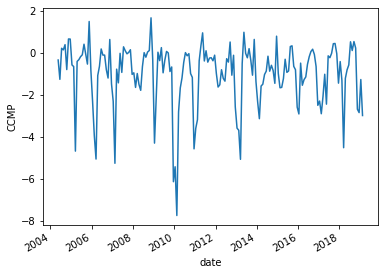

In [76]:
Ekman.CCMP.plot()
# xlim(start_date,'2019-5-1')

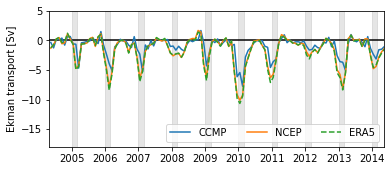

In [77]:
figure(figsize=(6,2.5))
axhline(0,color='k')
for var in Ekman:
    if var=='ERA5':
        Ekman[var].plot(label=var,linestyle='--')
    else:
        Ekman[var].plot(label=var)
ylabel('Ekman transport [Sv]')
xlim(start_date,'2014-5-15')
xlabel('')
[axvspan(str(xx)+'-1-1',str(xx)+'-3-1',color='grey',alpha=0.2) for xx in range(2005,2015)];
# [axvspan(str(xx)+'-6-1',str(xx)+'-9-1',color='darkgrey',alpha=0.4) for xx in range(2004,2022)];
gca().set_xticks([str(xx)+'-1-1' for xx in range(2005,2015)]);
# gca().set_xticklabels([str(xx) for xx in range(2005,2015)]);
ylim(-18,5)
legend(ncol=3,loc='lower right')#loc=(1.05,0.4))
xlabel('')
gca().set_xticklabels(labels=range(2005,2015),rotation=0,horizontalalignment ='center')
savefig(figdir+'EkmanComp.png',dpi=300,bbox_inches='tight')
savefig(figdir+'EkmanComp.pdf',bbox_inches='tight')

In [78]:
# Ekman.to_netcdf(datadir+'NASA_AMOC/Ekman_Step2.nc','w',format='netCDF4')

In [79]:
CCMP=xr.Dataset(coords={'date':pos.date.sel(date=slice(start_date,end_date)),'dist':ccmp.dist.values})


In [80]:
start_date

'2004-5-1'

In [81]:
end_date

'2019-4-1'

In [82]:
ccmp.Ekman_wdist.sel(date=slice(start_date,end_date))

<xarray.DataArray 'Ekman_wdist' (date: 179, dist: 280)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [-9.51658028e-05, -1.63416396e-04, -2.43478061e-04, ...,
         1.05520273e-03,  8.38906388e-04,  5.76900251e-04],
       [ 8.54642643e-04,  8.74649822e-04,  9.36138429e-04, ...,
        -4.29483833e-04, -2.95704715e-04, -1.01287067e-04],
       ...,
       [-8.82947932e-03, -9.00085126e-03, -9.20824076e-03, ...,
        -1.23876842e-03, -1.07038112e-03, -8.69510356e-04],
       [-7.86660319e-03, -8.22488979e-03, -8.62134886e-03, ...,
         3.60216933e-03,  3.21789994e-03,  2.60612925e-03],
       [-4.01394554e-03, -4.20058558e-03, -4.36972877e-03, ...,
         6.75475730e-03,  5.62737541e-03,  4.31851016e-03]])
Coordinates:
  * date     (date) datetime64[ns] 2004-05-09 2004-06-13 ... 2019-03-10
  * dist     (dist) float64 0.0 17.73 35.46 ... 6.118e+03 6.141e+03 6.164e+03
    time     (date) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [83]:
ccmp.Ekman_wdist

<xarray.DataArray 'Ekman_wdist' (date: 179, dist: 280)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [-9.51658028e-05, -1.63416396e-04, -2.43478061e-04, ...,
         1.05520273e-03,  8.38906388e-04,  5.76900251e-04],
       [ 8.54642643e-04,  8.74649822e-04,  9.36138429e-04, ...,
        -4.29483833e-04, -2.95704715e-04, -1.01287067e-04],
       ...,
       [-8.82947932e-03, -9.00085126e-03, -9.20824076e-03, ...,
        -1.23876842e-03, -1.07038112e-03, -8.69510356e-04],
       [-7.86660319e-03, -8.22488979e-03, -8.62134886e-03, ...,
         3.60216933e-03,  3.21789994e-03,  2.60612925e-03],
       [-4.01394554e-03, -4.20058558e-03, -4.36972877e-03, ...,
         6.75475730e-03,  5.62737541e-03,  4.31851016e-03]])
Coordinates:
  * date     (date) datetime64[ns] 2004-05-09 2004-06-13 ... 2019-03-10
  * dist     (dist) float64 0.0 17.73 35.46 ... 6.118e+03 6.141e+03 6.164e+03
    time     (date) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

In [84]:
CCMP['Ekman_wdist']=(('date','dist'),ccmp.Ekman_wdist.values)


In [86]:
CCMP.to_netcdf(datadir+'NASA_AMOC/Ekman_CCMP.nc','w',format='netCDF4')